# Udacity Capstone Project
## Starbucks Promotional Offers
### April 2023

# Data Sets
The data for this project are contained in three files:

- **portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
- **profile.json** - demographic data for each customer
- **transcript.json** - records for transactions, offers received, offers viewed, and offers completed

## Schema details
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - monetary reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle_data import clean_portfolio, clean_profile, clean_transcript, merge_data, age_bins, income_bins
from recommendations import create_ranked_offers, popular_recommendations, create_user_item_matrix
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### portfolio.json

In [3]:
# look at first few rows
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# shape of portfolio data
print('Number of portfolio data rows: {}'.format(portfolio.shape[0]))
print('Number of portfolio data columns: {}'.format(portfolio.shape[1]))

Number of portfolio data rows: 10
Number of portfolio data columns: 6


In [5]:
# column information
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
# any missing values
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
# summary stats
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0


In [8]:
# how many unique offer ids
print('Unique offer ids: {}'.format(portfolio.id.nunique()))

Unique offer ids: 10


In [9]:
# distribution of offer ids
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [10]:
# distribution of offer durations
portfolio.duration.value_counts()

7     4
5     2
10    2
4     1
3     1
Name: duration, dtype: int64

### profile.json

In [11]:
# look at first few rows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# shape of profile data
print('Number of profile data rows: {}'.format(profile.shape[0]))
print('Number of profile data columns: {}'.format(profile.shape[1]))

Number of profile data rows: 17000
Number of profile data columns: 5


In [13]:
# column information
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
# any missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
# summary stats
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


In [16]:
profile.loc[profile['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### transcript.json

In [18]:
# look at first few rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
# shape of transcript data
print('Number of transcript data rows: {}'.format(transcript.shape[0]))
print('Number of transcript data columns: {}'.format(transcript.shape[1]))

Number of transcript data rows: 306534
Number of transcript data columns: 4


In [20]:
# column information
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
# any missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [22]:
# what are the unique events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [23]:
# what are the event counts
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
# what does a transaction value look like
transcript.query('event == "transaction"')['value'].iloc[0]

{'amount': 0.8300000000000001}

In [25]:
# what does a offer received value look like
transcript.query('event == "offer received"')['value'].iloc[0]

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [26]:
# what does a offer viewed value look like
transcript.query('event == "offer viewed"')['value'].iloc[0]

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

In [27]:
# what does a offer completed value look like
transcript.query('event == "offer completed"')['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

### Data Observations
#### portfolio.json
- channels can be one-hot encoded
- offer_type can be one-hot encoded
- id column is offer_id
- there are no missing values

#### profile.json 
- id in this data set is a customer id
- gender and income each have 2175 missing values. 
- maximum age is 118, which appears out of line. 
- age = 118 is in the same 2175 records with missing gender and income.
- became_member_on is a data field, but represented as integer

#### transcript.json 
- time column represents hours since start of test, but is integer format
- people column is equivalent to customer id in profile dataset

## Data Cleaning

#### portfolio dataframe
- rename "id" column to "offer_id"
- rename "duration" column to "days_open"
- rename "difficulty" column to "min_spend"
- one-hot encode "channels" column
- one-hot encode "offer_type" column
- drop "channels" and "offer_type" columns after one-hot encoding

In [28]:
# call clean_portfolio function to clean the portfolio dataset
portfolio_clean = clean_portfolio()
portfolio_clean

,offer_id,reward,min_spend,days_open,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,0,1,0,1,0


#### profile dataframe
- rename "id" column to "customer_id"
- remove the 2175 rows where "gender" and "income" have missing values and "age" equals 118
- one-hot encode 'gender' column
- convert "became_member_on" to datetime and label "membership_start"
- create "membership_year" from "membership_start"
- reorder columns

In [29]:
# call clean_profile to clean profile data
profile_clean = clean_profile()
profile_clean.head()

,customer_id,age,income,female,male,membership_start,membership_year
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,2017-07-15,2017
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,2017-05-09,2017
5,e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,2018-04-26,2018
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,2018-02-09,2018
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,2017-11-11,2017


#### transcript dataframe
- rename 'person' column to 'customer_id'
- one-hot encode 'event' column
- split transcript dataframe into transaction and offers dataframes
- extract 'offer_id' from 'value' column
- extract 'transaction' from 'value' column
- drop unneeded columns

In [30]:
# call clean_transcript to clean transcript data
offers, transactions = clean_transcript()

In [31]:
offers.head(2)

,offer_id,customer_id,time,offer_completed,offer_received,offer_viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,0,1,0


In [32]:
transactions.head(2)

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56


In [33]:
# call merge_data to merge cleaned data sets and write out offers and transactions csv files 
merge_data(portfolio_clean, profile_clean, offers, transactions)

In [34]:
# read in cleaned offers data and display first couple of rows
offers_df = pd.read_csv('data/starbucks_offers_data.csv')
offers_df.head(2)

,offer_id,customer_id,time,offer_completed,offer_received,offer_viewed,reward,min_spend,days_open,email,...,web,bogo,discount,informational,age,income,female,male,membership_start,membership_year
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,5,5,7,1,...,1,1,0,0,75.0,100000.0,1.0,0.0,2017-05-09,2017.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,5,20,10,1,...,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# read in cleaned transactions data and display first couple of rows
transactions_df = pd.read_csv('data/starbucks_transact_data.csv')
transactions_df.head(2)

,customer_id,time,amount,age,income,female,male,membership_start,membership_year
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,20.0,30000.0,1.0,0.0,2016-07-11,2016.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,42.0,96000.0,0.0,1.0,2016-01-17,2016.0


## Data Exploration and Analysis

For comparison, it may be useful to have 'age' and 'income' ranges.

In [36]:
# 'age' summary stats - offers dataset
offers_df['age'].describe().T

count    148805.000000
mean         54.779282
std          17.193533
min          18.000000
25%          43.000000
50%          56.000000
75%          67.000000
max         101.000000
Name: age, dtype: float64

In [37]:
# 'income' summary stats - offers dataset
offers_df['income'].describe().T

count    148805.000000
mean      66414.119149
std       21496.947967
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: income, dtype: float64

In [38]:
# 'age' summary stats - transactions dataset
transactions_df['age'].describe().T

count    123957.000000
mean         52.713965
std          17.906667
min          18.000000
25%          39.000000
50%          54.000000
75%          65.000000
max         101.000000
Name: age, dtype: float64

In [39]:
# 'income' summary stats - transactions dataset
transactions_df['income'].describe().T

count    123957.000000
mean      61843.510250
std       20661.890394
min       30000.000000
25%       46000.000000
50%       60000.000000
75%       74000.000000
max      120000.000000
Name: income, dtype: float64

In [40]:
# create age bins in offers dataset
offers_df = age_bins(offers_df)
offers_df.head()

,offer_id,customer_id,time,offer_completed,offer_received,offer_viewed,reward,min_spend,days_open,email,...,female,male,membership_start,membership_year,18-29,30-44,45-59,60-74,75-89,90-101
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,5,5,7,1,...,1.0,0.0,2017-05-09,2017.0,0,0,0,0,1,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,5,20,10,1,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,0,1,0,2,10,7,1,...,0.0,1.0,2018-04-26,2018.0,0,0,0,1,0,0
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,2,10,10,1,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,10,10,5,1,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [41]:
# create age bins in transactions dataset
transactions_df = age_bins(transactions_df)
transactions_df.head()

,customer_id,time,amount,income,female,male,membership_start,membership_year,18-29,30-44,45-59,60-74,75-89,90-101
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,30000.0,1.0,0.0,2016-07-11,2016.0,1,0,0,0,0,0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,96000.0,0.0,1.0,2016-01-17,2016.0,0,1,0,0,0,0
2,54890f68699049c2a04d415abc25e717,0,13.23,56000.0,0.0,1.0,2017-12-28,2017.0,0,1,0,0,0,0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,94000.0,1.0,0.0,2017-10-16,2017.0,0,0,1,0,0,0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,67000.0,1.0,0.0,2017-12-17,2017.0,0,1,0,0,0,0


In [42]:
# create income bins in offers dataset
offers_df = income_bins(offers_df)
offers_df.head()

,offer_id,customer_id,time,offer_completed,offer_received,offer_viewed,reward,min_spend,days_open,email,...,30-44,45-59,60-74,75-89,90-101,30k-49k,50k-69k,70k-89k,90k-109k,110k-120k
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,5,5,7,1,...,0,0,0,1,0,0,0,0,1,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,5,20,10,1,...,0,0,0,0,0,0,0,0,0,0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,0,1,0,2,10,7,1,...,0,0,1,0,0,0,0,1,0,0
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,2,10,10,1,...,0,0,0,0,0,0,0,0,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,10,10,5,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# create income bins in transactions dataset
transactions_df = income_bins(transactions_df)
transactions_df.head()

,customer_id,time,amount,female,male,membership_start,membership_year,18-29,30-44,45-59,60-74,75-89,90-101,30k-49k,50k-69k,70k-89k,90k-109k,110k-120k
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,1.0,0.0,2016-07-11,2016.0,1,0,0,0,0,0,0,0,0,0,0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,0.0,1.0,2016-01-17,2016.0,0,1,0,0,0,0,0,0,0,1,0
2,54890f68699049c2a04d415abc25e717,0,13.23,0.0,1.0,2017-12-28,2017.0,0,1,0,0,0,0,0,1,0,0,0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,1.0,0.0,2017-10-16,2017.0,0,0,1,0,0,0,0,0,0,1,0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1.0,0.0,2017-12-17,2017.0,0,1,0,0,0,0,0,1,0,0,0


### Look at some simple frequency distributions

In [44]:
# create age and income dictionaries
age_cols = ['18-29', '30-44', '45-59', '60-74', '75-89', '90-101']
income_cols = ['30k-49k', '50k-69k', '70k-89k', '90k-109k', '110k-120k']

In [45]:
# age distribution in offers
offers_age_dist = offers_df[offers_df['offer_completed'] == 1][age_cols].sum()
offers_age_dist

18-29      2577
30-44      5126
45-59     11014
60-74      9351
75-89      3618
90-101      629
dtype: int64

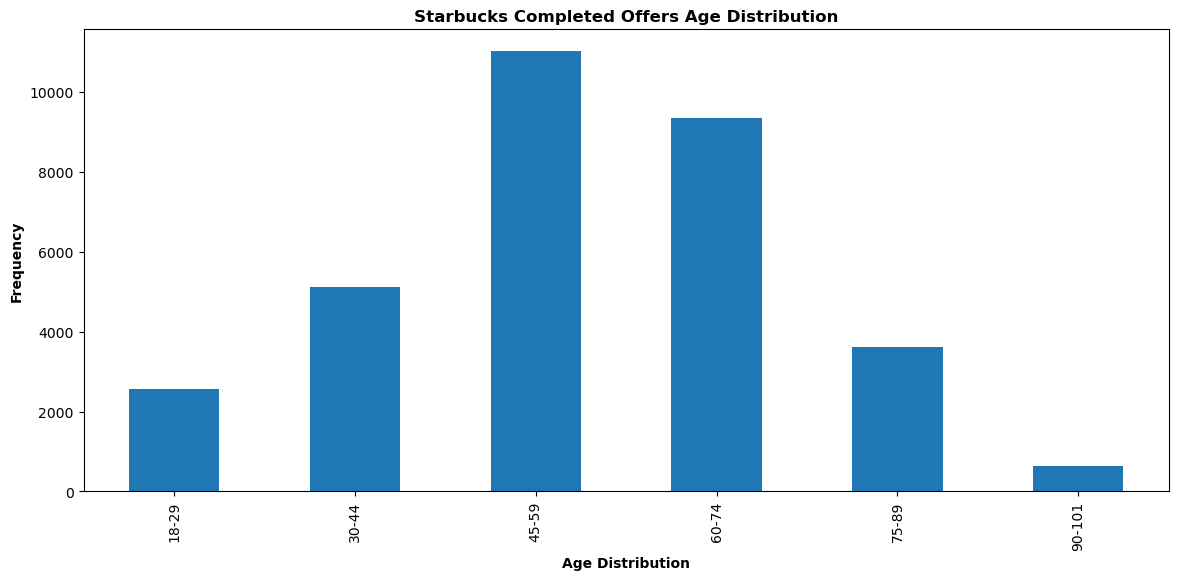

In [46]:
# plot offers age distribution
plt.figure(figsize = (14, 6))
offers_age_dist.plot(kind = 'bar')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Age Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 45-years to 74-years age group.

In [47]:
# income distribution in offers
offers_income_dist = offers_df[offers_df['offer_completed'] == 1][income_cols].sum()
offers_income_dist

30k-49k       5943
50k-69k      10521
70k-89k       9535
90k-109k      4865
110k-120k     1460
dtype: int64

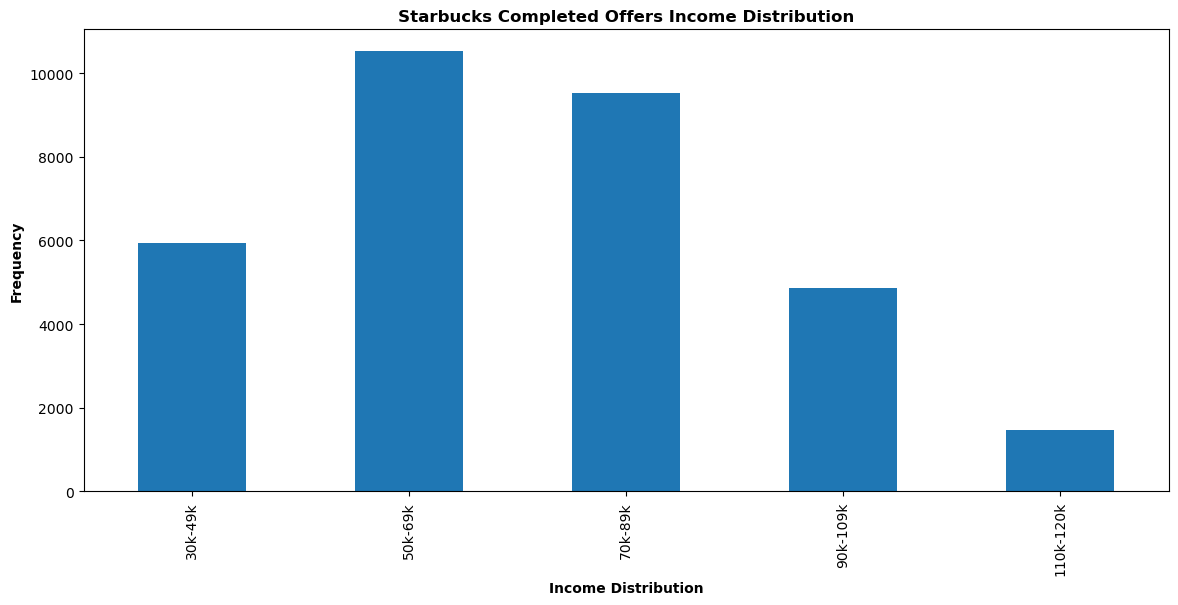

In [48]:
# plot offers age distribution
plt.figure(figsize = (14, 6))
offers_income_dist.plot(kind = 'bar')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Income Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 50,000 - 89,000 income range.

In [49]:
# offer type distribution in offers
offer_type_cols = ['bogo', 'discount']
offer_type_dist = offers_df[offers_df['offer_completed'] == 1][offer_type_cols].sum()
offer_type_dist

bogo        15669
discount    17910
dtype: int64

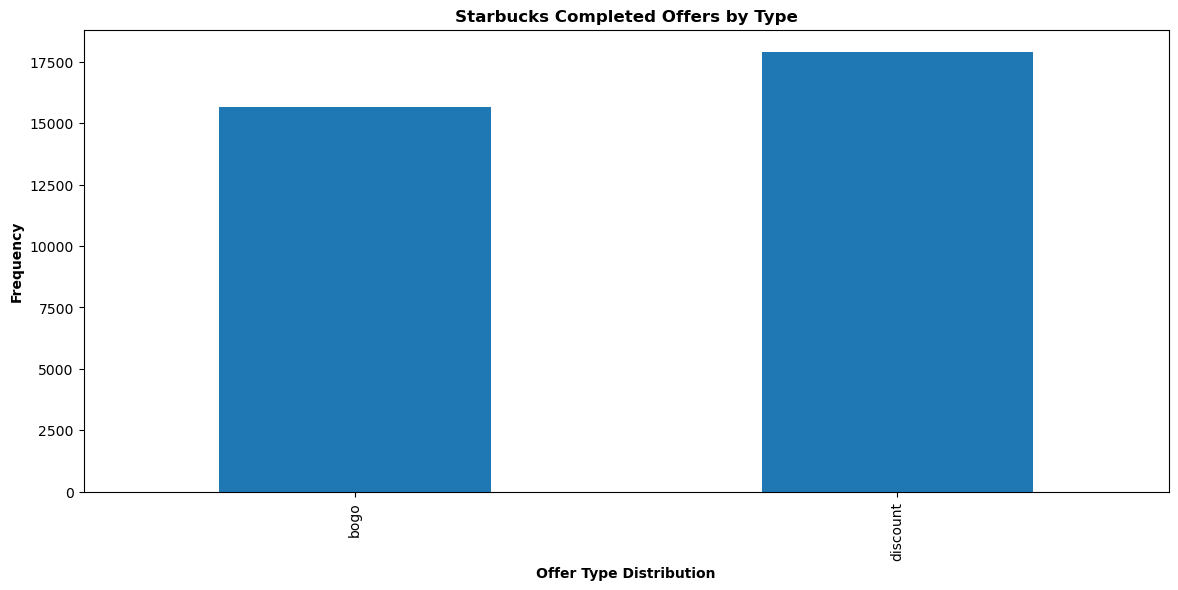

In [50]:
# plot offer type distribution
plt.figure(figsize = (14, 6))
offer_type_dist.plot(kind = 'bar')
plt.xlabel('Offer Type Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Type', weight = 'bold');

> Discount offers are slightly more prevelant than bogo.

In [51]:
channels_cols = ['email', 'mobile', 'social', 'web']
offer_channels_dist = offers_df[offers_df['offer_completed'] == 1][channels_cols].sum()
offer_channels_dist

email     33579
mobile    30159
social    21788
web       29891
dtype: int64

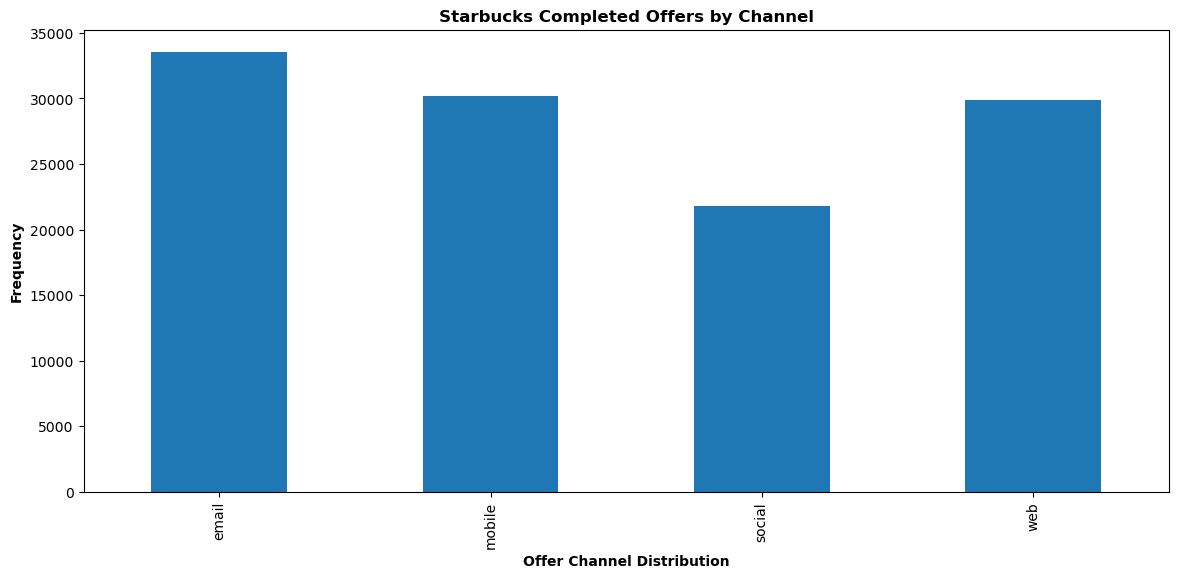

In [52]:
# plot offer channel distribution
plt.figure(figsize = (14, 6))
offer_channels_dist.plot(kind = 'bar')
plt.xlabel('Offer Channel Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Channel', weight = 'bold');

> Email channel frequency is slightly higher than mobile and web.

In [53]:
# offer type distribution in offers
gender_cols = ['male', 'female']
gender_dist = offers_df[offers_df['offer_completed'] == 1][gender_cols].sum()
gender_dist

male      16466.0
female    15477.0
dtype: float64

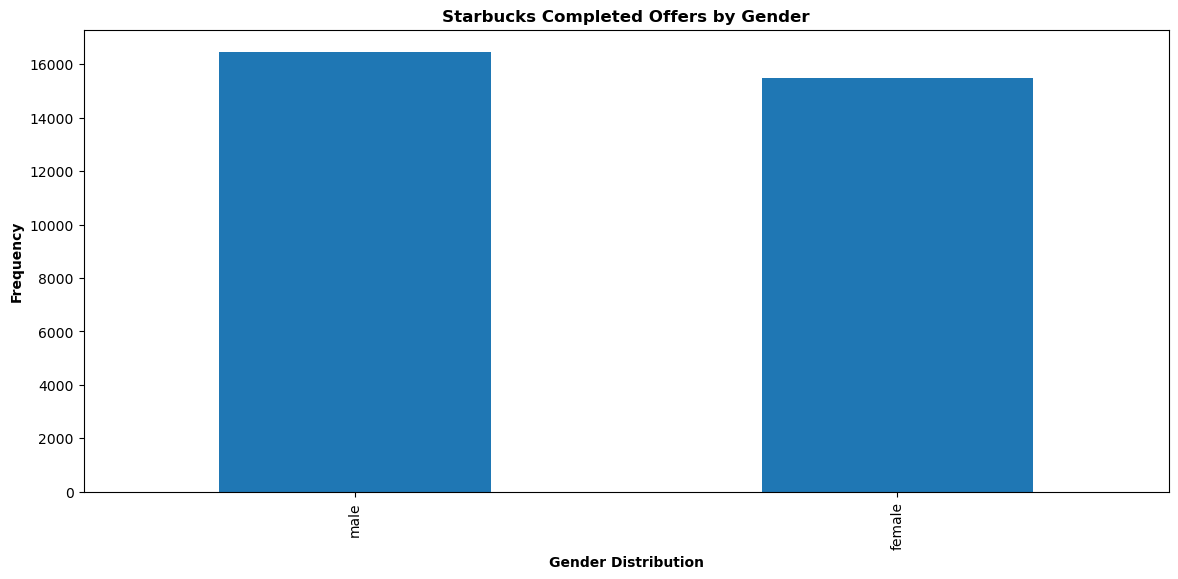

In [54]:
# plot gender distribution
plt.figure(figsize = (14, 6))
gender_dist.plot(kind = 'bar')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Gender', weight = 'bold');

> Slightly higher number of completed offers for male customers.

In [55]:
# age distribution of transaction data
transaction_age_dist = transactions_df[age_cols].sum()
transaction_age_dist

18-29     15528
30-44     24294
45-59     37873
60-74     31511
75-89     12022
90-101     2030
dtype: int64

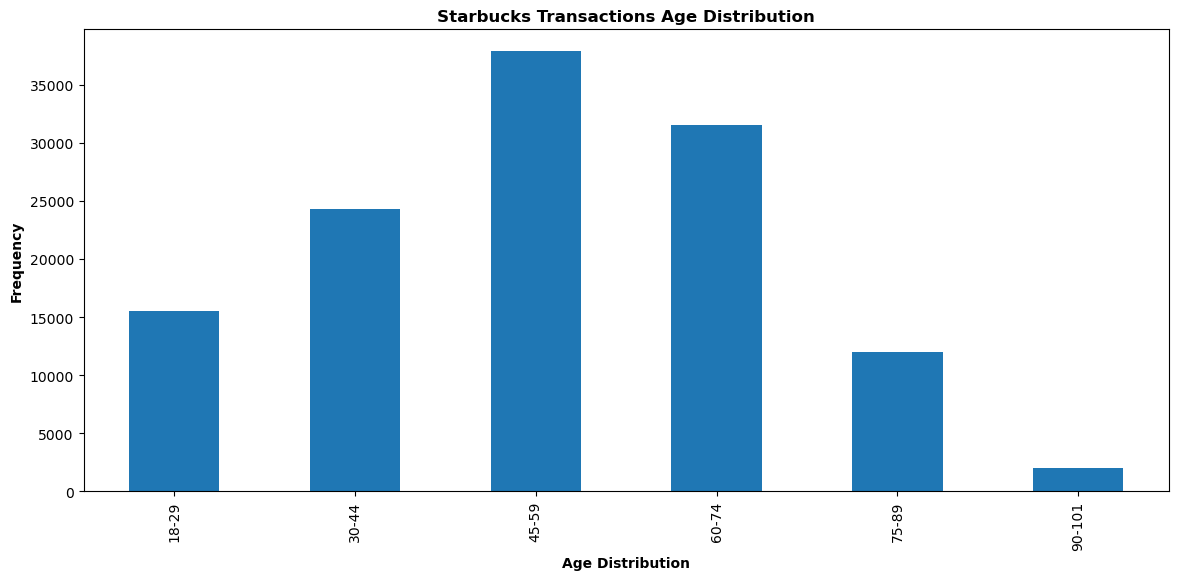

In [56]:
# plot transaction age distribution
plt.figure(figsize = (14, 6))
transaction_age_dist.plot(kind = 'bar')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Age Distribution', weight = 'bold');

> Similar to the completed offers data, the bulk of transaction data is in the 45-years to 74-years age groups.

In [57]:
# income distribution of transaction data
transaction_income_dist = transactions_df[income_cols].sum()
transaction_income_dist

30k-49k      37075
50k-69k      45035
70k-89k      26610
90k-109k     11178
110k-120k     3185
dtype: int64

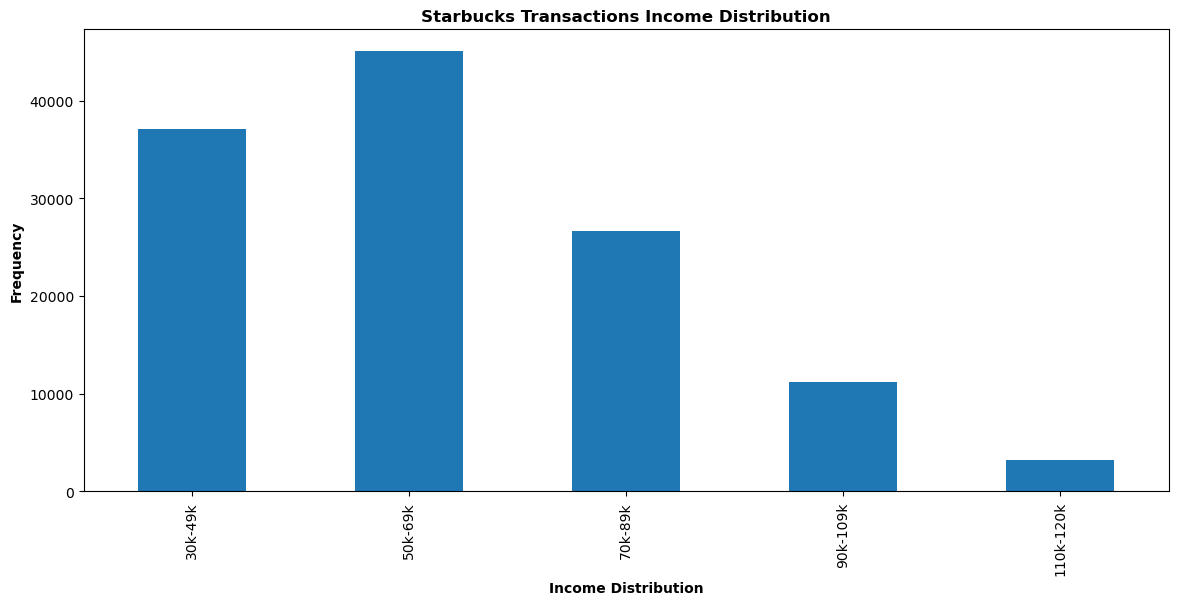

In [58]:
# plot transaction income distribution
plt.figure(figsize = (14, 6))
transaction_income_dist.plot(kind = 'bar')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Income Distribution', weight = 'bold');

> Income distribution is shifted lower with the transaction data, with the bulk in the 30,000 to 69,000 range.

In [59]:
# income distribution of transaction data
transaction_gender_dist = transactions_df[gender_cols].sum()
transaction_gender_dist

male      72794.0
female    49382.0
dtype: float64

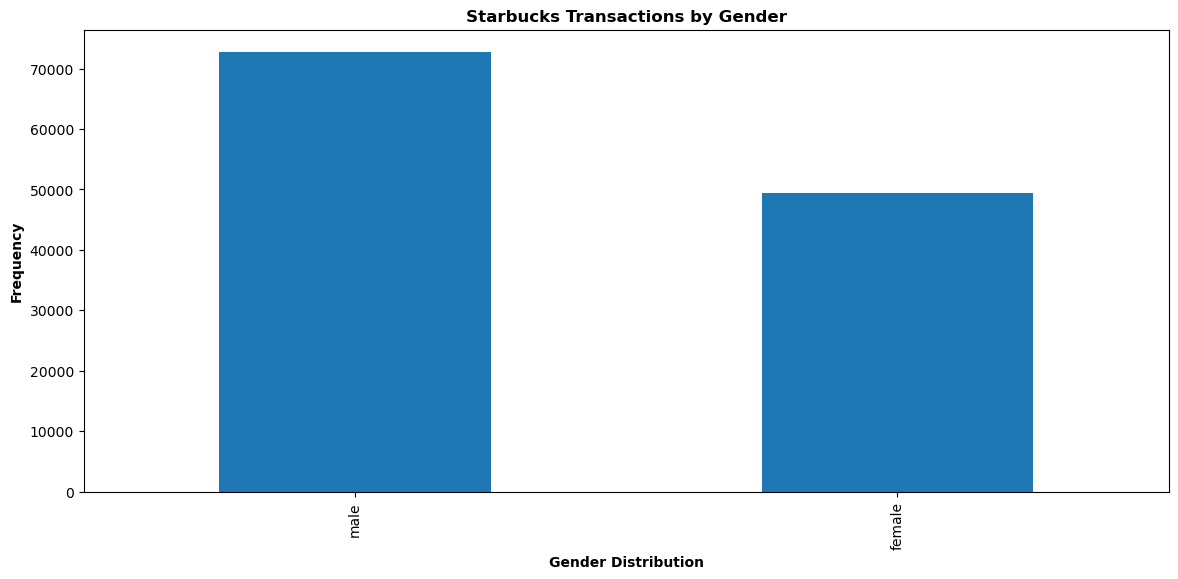

In [60]:
# plot gender distribution
plt.figure(figsize = (14, 6))
transaction_gender_dist.plot(kind = 'bar')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions by Gender', weight = 'bold');

> Transactions for males are significantly higher.

## Recommendations

In [61]:
ranked_completed = create_ranked_offers(offers_df)
ranked_completed

,offer_id,offer_received,offer_completed,completion_ratio
9,fafdcd668e3743c1bb461111dcafc2a4,7597,5317,0.699882
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5156,0.674340
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,4296,0.567428
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4354,0.567149
2,2906b810c7d4411798c6938adc9daaa5,7632,4017,0.526336
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,3688,0.481588
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,3420,0.446009
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3331,0.438694
3,3f207df678b143eea3cee63160fa8bed,7617,0,0.000000
5,5a8bc65990b245e5a138643cd4eb9837,7618,0,0.000000


In [62]:
recs_5 = popular_recommendations(ranked_completed, 5)
recs_5

The top  5  offer recommendations: 


['fafdcd668e3743c1bb461111dcafc2a4',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '2906b810c7d4411798c6938adc9daaa5']

In [63]:
user_item = create_user_item_matrix(offers_df)
user_item.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,1,1,0,1,0,0,1,1
00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,1,0
0011e0d4e6b944f998e987f904e8c1e5,1,1,0,1,0,1,1,0,0,0
0020c2b971eb4e9188eac86d93036a77,0,0,0,0,1,1,0,1,0,1
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0,0,0,1,1,0,1,0


In [64]:
user_item.shape[0]

16994

In [65]:
def offers_completed(user_item, customer_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    offers = user_item.loc[customer_id][user_item.loc[customer_id].isnull() == False].index.values

    return offers

In [66]:
def create_user_offer_dict(user_item):
    '''
    INPUT: None
    OUTPUT: movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    Creates the movies_seen dictionary
    '''
    n_users = user_item.shape[0]
    offers_seen = dict()

    for user in range(1, n_users+1):
        
        # assign list of movies to each user key
        print(user)
        offers_seen[user] = offers_completed(user_item, user)
        print(offer_seen[user])
    
    return offers_seen

In [67]:
offers_completed(user_item, '0020ccbbb6d84e358d3414a3ff76cffd')

array(['0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '5a8bc65990b245e5a138643cd4eb9837',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       'fafdcd668e3743c1bb461111dcafc2a4'], dtype=object)

In [68]:
offers_seen = create_user_offer_dict(user_item)

1


KeyError: 1